# Molecular Dynamics: Stability

Before continue, you should have:

- installed GROMACS
- put CHARMM36 force field in the correct location
- generated a backbone structure
- predicted the sequence of the generated structure
- modelled and added side chains to the structure
- added H atoms to the structure

In [1]:
import os

os.environ['PATH'] = '/usr/local/gromacs/bin:' + os.environ['PATH']

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

In [3]:
PROTEIN_CLS = PROTEIN_CLS if "PROTEIN_CLS" in locals() else "GFP"
PROTEIN_SID = PROTEIN_SID if "PROTEIN_SID" in locals() else "SM_17"
assert PROTEIN_CLS is not None
assert PROTEIN_SID is not None
PROTEIN_PDB = Path(f"../../data/{PROTEIN_CLS}/generated/BQSH/{PROTEIN_SID}.pdb")

# Create a new working directory!
WD = Path(f"wd-md1/{PROTEIN_CLS}/{PROTEIN_SID}")
WD.mkdir(parents=True, exist_ok=True)

# TOOLS: Change the path accordingly
GROMACS_PATH = "~/WS/ProtMatch/gromacs"

Cleaning the input structure

Strip out all the atoms that do not belong to the protein (e.i crystal waters, ligands, etc).

In [4]:
PROTEIN_TMP = Path(f"{PROTEIN_PDB.name}_tmp.pdb")
!grep -v HETATM {PROTEIN_PDB} > {WD}/{PROTEIN_TMP}

PROTEIN_PDB = Path(PROTEIN_PDB.name)
!cd {WD} && grep -v CONECT {PROTEIN_TMP} > {PROTEIN_PDB}

!cd {WD} && rm -f {PROTEIN_TMP}
del PROTEIN_TMP

Move the protein to the origin.

In [5]:
PROTEIN_TMP = Path(f"{PROTEIN_PDB.stem}.pdb")
!cd {WD} && vmd -dispdev text -eofexit -args < {GROMACS_PATH}/to_origin.tcl {PROTEIN_PDB} {PROTEIN_TMP}
PROTEIN_PDB = PROTEIN_TMP
del PROTEIN_TMP

Info) VMD for LINUXAMD64, version 1.9.4a57 (April 27, 2022)
Info) http://www.ks.uiuc.edu/Research/vmd/                         
Info) Email questions and bug reports to vmd@ks.uiuc.edu           
Info) Please include this reference in published work using VMD:   
Info)    Humphrey, W., Dalke, A. and Schulten, K., `VMD - Visual   
Info)    Molecular Dynamics', J. Molec. Graphics 1996, 14.1, 33-38.
Info) -------------------------------------------------------------
Info) Multithreading available, 24 CPUs.
Info)   CPU features: SSE2 SSE4.1 AVX AVX2 FMA F16 HT 
Info)   Detected VM or hypervisor execution environment
Info) Free system memory: 29GB (92%)
Info) Creating CUDA device pool and initializing hardware...
Info) Unable to load NVML library, GPU-CPU affinity unavailable.
Info) Detected 1 available CUDA accelerator::
Info) [0] NVIDIA GeForce RTX 4090 128 SM_8.9 2.6 GHz, 24GB RAM SP64 KT AE1 ZC
OptiXRenderer) ERROR: Failed to load OptiX shared library.
OptiXRenderer)        NVIDIA drive

## Setting Up the Simulation Box and Converting File Format

- Distance between the solute and the box: 15 nm
- Box type: octahedron
- Center molecule in box.

In [6]:
PROTEIN_GRO = Path(f"{PROTEIN_PDB.stem}.gro")
!cd {WD} && gmx editconf -f {PROTEIN_PDB} -o {PROTEIN_GRO} -c -d 1.5 -bt octahedron

                     :-) GROMACS - gmx editconf, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/ProtMatch/notebooks/MD1/GFP/SM_17
Command line:
  gmx editconf -f SM_17.pdb -o SM_17.gro -c -d 1.5 -bt octahedron

Note that major changes are planned in future for editconf, to improve usability and utility.
Read 3682 atoms
Volume: 0 nm^3, corresponds to roughly 0 electrons
No velocities found
    system size :  5.518  5.248  4.102 (nm)
    diameter    :  6.545               (nm)
    center      :  0.002 -0.017 -0.025 (nm)
    box vectors :  0.000  0.000  0.000 (nm)
    box angles  :   0.00   0.00   0.00 (degrees)
    box volume  :   0.00               (nm^3)
    shift       :  4.770  6.766  3.922 (nm)
new center      :  4.772  6.749  3.897 (nm)
new box vectors :  9.545  9.545  9.545 (nm)
new box angles  :  70.53 109.47  70.53 (degrees)
new box volume  : 669.36               (nm^3)

GROMACS reminds you: "You see it through 

## Generating Topology with CHARMM36 Force Field

Generate the topology for the protein structure using the **charmm36** force field and the **TIP3P** water model.
The topology file defines the molecular structure, including atomic types, charges, and bonding information, which is essential for subsequent molecular dynamics simulations.

> (From GROMACS 2024 Manual)
> CHARMM (Chemistry at HARvard Macromolecular Mechanics) is a both a set of force fields and a software package for molecular dynamics (page 328) simulations and analysis. Includes united atom (CHARMM19) and all atom (CHARMM22, CHARMM27, CHARMM36) force fields (page 328). The CHARMM27 force field has been ported to GROMACS and is officially supported. CHARMM36 force field files can be obtained from the MacKerell lab website, which regularly produces up-to-date CHARMM force field files in GROMACS format.
> 
> For using CHARMM36 in GROMACS, please use the following settings in the mdp (page 483) file:
> ```
> constraints = h-bonds
> cutoff-scheme = Verlet
> vdwtype = cutoff
> vdw-modifier = force-switch
> rlist = 1.2
> rvdw = 1.2
> rvdw-switch = 1.0
> coulombtype = PME
> rcoulomb = 1.2
> DispCorr = no
> ```
> Note that dispersion correction should be applied in the case of lipid monolayers, but not bilayers.
> Please also note that the switching distance is a matter of some debate in lipid bilayer simulations, and it is dependent to some extent on the nature of the lipid. Some studies have found that an 0.8-1.0 nm switch is appropriate, others argue 0.8-1.2 nm is best, and yet others stand by 1.0-1.2 nm. The user is cautioned to thoroughly investigate the force field literature for their chosen lipid(s) before beginning a simulation!


In [7]:
PROTEIN_TOP_GRO = Path(f"{PROTEIN_PDB.stem}_top.gro")
PROTEIN_TOP = Path(f"{PROTEIN_PDB.stem}.top")
FF_PATH = Path("../../gromacs/charmm36-jul2022.ff")
!cp -r {FF_PATH} {WD}
# !cd {WD} && gmx pdb2gmx -f {PROTEIN_GRO} -o {PROTEIN_TOP_GRO} -p {PROTEIN_TOP} -water tip3p -ff charmm36-jul2022
# Any errors check https://manual.gromacs.org/2021.4/user-guide/run-time-errors.html.
# If a fatal error occurred due to H, this atom may not defined in the FF.
# Consider to remove this atom from PDB, or (not recommended) ignore hydrogen atoms with `-ignh`.
# If atom C1 not found in buiding block 1MET while combining tdb and rtp, you may need `-ter`.
# Check more at https://gromacs.bioexcel.eu/t/newest-charmm36-port-for-gromacs/868/11.
# !cd {WD} && echo "1 0" | gmx pdb2gmx -f {PROTEIN_GRO} -o {PROTEIN_TOP_GRO} -p {PROTEIN_TOP} -water tip3p -ff charmm36-jul2022 -ignh -ter
!cd {WD} && gmx pdb2gmx -f {PROTEIN_GRO} -o {PROTEIN_TOP_GRO} -p {PROTEIN_TOP} -water tip3p -ff charmm36-jul2022 -ignh

                     :-) GROMACS - gmx pdb2gmx, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/ProtMatch/notebooks/MD1/GFP/SM_17
Command line:
  gmx pdb2gmx -f SM_17.gro -o SM_17_top.gro -p SM_17.top -water tip3p -ff charmm36-jul2022 -ignh -ter

Using the Charmm36-jul2022 force field in directory ./charmm36-jul2022.ff

going to rename ./charmm36-jul2022.ff/aminoacids.r2b
Opening force field file ./charmm36-jul2022.ff/aminoacids.r2b

going to rename ./charmm36-jul2022.ff/carb.r2b
Opening force field file ./charmm36-jul2022.ff/carb.r2b

going to rename ./charmm36-jul2022.ff/cgenff.r2b
Opening force field file ./charmm36-jul2022.ff/cgenff.r2b

going to rename ./charmm36-jul2022.ff/ethers.r2b
Opening force field file ./charmm36-jul2022.ff/ethers.r2b

going to rename ./charmm36-jul2022.ff/lipid.r2b
Opening force field file ./charmm36-jul2022.ff/lipid.r2b

going to rename ./charmm36-jul2022.ff/metals.r2b
Opening force field 

## Running Energy Minimization

Create a `.tpr` file which is a portable binary run input file that contains all the necessary information for performing an energy minimization on the protein structure in a vacuum.
Ensure that the structure is stable and free from significant steric clashes or unrealistic geometries before proceeding to further simulations.

In [8]:
MIN_SD_MDP = Path(GROMACS_PATH) / "min_sd.mdp"
VACUUM_TPR = Path(f"{PROTEIN_PDB.stem}_vacuum.tpr")
!cd {WD} && gmx grompp -v -f {MIN_SD_MDP} -c {PROTEIN_TOP_GRO} -p {PROTEIN_TOP} -o {VACUUM_TPR} -maxwarn 1

                      :-) GROMACS - gmx grompp, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/ProtMatch/notebooks/MD1/GFP/SM_17
Command line:
  gmx grompp -v -f /home/tz365/WS/ProtMatch/gromacs/min_sd.mdp -c SM_17_top.gro -p SM_17.top -o SM_17_vacuum.tpr -maxwarn 1

Ignoring obsolete mdp entry 'ns_type'
checking input for internal consistency...

Setting the LD random seed to -775952516

processing topology...

Generated 167799 of the 167910 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein'

NOTE 1 [file SM_17.top, line 35421]:
  System has non-zero total charge: 5.000000
  Total charge should normally be an integer. See
  https://manual.gromacs.org/current/user-guide/floating-point.html
  for discussion on how close it should be to an integer.




WARNING 1 [file SM_17.top, line 354

Perform an energy minimization on the protein structure in a vacuum.
This is to eliminate any steric clashes or inappropriate geometry in the molecular structure.
It adjusts the positions of atoms to find a local minimum in the potential energy landscape, leading to a more stable conformation.

In [9]:
VACUUM_GRO = Path(f"{VACUUM_TPR.stem}.gro")
!cd {WD} && gmx mdrun -v -deffnm {VACUUM_TPR.stem} -c {VACUUM_GRO} -gpu_id 0

                      :-) GROMACS - gmx mdrun, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/ProtMatch/notebooks/MD1/GFP/SM_17
Command line:
  gmx mdrun -v -deffnm SM_17_vacuum -c SM_17_vacuum.gro -gpu_id 0

Reading file SM_17_vacuum.tpr, VERSION 2024.2 (single precision)
1 GPU selected for this run.
Mapping of GPU IDs to the 1 GPU task in the 1 rank on this node:
  PP:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the CPU
Using 1 MPI thread
Using 24 OpenMP threads 


Steepest Descents:
   Tolerance (Fmax)   =  2.00000e+00
   Number of steps    =        30000
Step=    0, Dmax= 1.0e-02 nm, Epot=  9.24104e+04 Fmax= 6.97744e+05, atom= 984
Step=    1, Dmax= 1.0e-02 nm, Epot=  7.50174e+04 Fmax= 1.26585e+05, atom= 3619
Step=    2, Dmax= 1.2e-02 nm, Epot=  6.07109e+04 Fmax= 3.99093e+04, atom= 3636
Step=    3, Dmax= 1.4e-02 nm, Epot=  4.36668e+04 Fmax= 

Analyse and visualize the energy minimization results.

                      :-) GROMACS - gmx energy, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/ProtMatch/notebooks/MD1/GFP/SM_17
Command line:
  gmx energy -f SM_17_vacuum.edr -o SM_17_vacuum.xvg -xvg none

Opened SM_17_vacuum.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Potential       12  Pressure      
 13  Vir-XX          14  Vir-XY          15  Vir-XZ          16  Vir-YX        
 17  Vir-YY          18  Vir-YZ          19  Vir-ZX          20  Vir-ZY        
 21  Vir-ZZ          22  Pres-

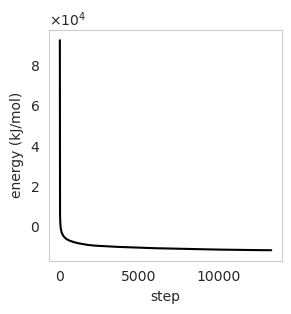

In [10]:
VACUUM_EDR = Path(f"{VACUUM_GRO.stem}.edr")
VACUUM_XVG = Path(f"{VACUUM_GRO.stem}.xvg")
!cd {WD} && echo "11" | gmx energy -f {VACUUM_EDR} -o {VACUUM_XVG} -xvg none

fig, ax = plt.subplots(figsize=(3, 3))
df = pd.read_csv(WD / VACUUM_XVG, sep='\s+', header=None, names=['step', 'energy'])
plt.plot(df["step"], df["energy"], color="black")
plt.xlabel("step")
plt.ylabel("energy (kJ/mol)")
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.grid(False)
plt.show()

## Solvating the System

Surrounding the protein with water molecules to create a realistic biological environment for molecular dynamics simulations.

In [11]:
WATER_GRO = Path(f"{PROTEIN_PDB.stem}_water.gro")
!cd {WD} && gmx solvate -cp {VACUUM_GRO} -cs spc216.gro -p {PROTEIN_TOP} -o {WATER_GRO}

                     :-) GROMACS - gmx solvate, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/ProtMatch/notebooks/MD1/GFP/SM_17
Command line:
  gmx solvate -cp SM_17_vacuum.gro -cs spc216.gro -p SM_17.top -o SM_17_water.gro

Reading solute configuration
Reading solvent configuration

Initialising inter-atomic distances...

         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.

NOTE: From version 5.0 gmx solvate uses the Van der Waals radii
from the source below. This means the results may be different
compared to previous GROMACS versions.

Remove any water molecules that may have inadvertently entered the core of the protein (within 3 Ångströms of the protein) during the solvation process.
Internal water molecules within the protein core can interfere with the protein's structure and function.

In [12]:
WATER_RM_GRO = Path(f"{PROTEIN_PDB.stem}_waterRM.gro")
DEL_H2O_TCL = Path(GROMACS_PATH) / "del_wat_inside.tcl"
!cd {WD} && vmd -dispdev text -eofexit -args < {DEL_H2O_TCL} {WATER_GRO} {PROTEIN_TOP} {WATER_RM_GRO}

Info) VMD for LINUXAMD64, version 1.9.4a57 (April 27, 2022)
Info) http://www.ks.uiuc.edu/Research/vmd/                         
Info) Email questions and bug reports to vmd@ks.uiuc.edu           
Info) Please include this reference in published work using VMD:   
Info)    Humphrey, W., Dalke, A. and Schulten, K., `VMD - Visual   
Info)    Molecular Dynamics', J. Molec. Graphics 1996, 14.1, 33-38.
Info) -------------------------------------------------------------
Info) Multithreading available, 24 CPUs.
Info)   CPU features: SSE2 SSE4.1 AVX AVX2 FMA F16 HT 
Info)   Detected VM or hypervisor execution environment
Info) Free system memory: 29GB (92%)
Info) Creating CUDA device pool and initializing hardware...
Info) Unable to load NVML library, GPU-CPU affinity unavailable.
Info) Detected 1 available CUDA accelerator::
Info) [0] NVIDIA GeForce RTX 4090 128 SM_8.9 2.6 GHz, 24GB RAM SP64 KT AE1 ZC
OptiXRenderer) ERROR: Failed to load OptiX shared library.
OptiXRenderer)        NVIDIA drive

You may need to correct formatting issues in the GRO file generated during the molecular dynamics simulation setup process.
See https://github.com/allison-group/structural-phylogenetics-bootstrap/blob/master/MD/GMX/fix_gro.py

## Energy Minimization After Adding Waters

In [13]:
WATER_RM_TPR = Path(f"{WATER_RM_GRO.stem}.tpr")
!cd {WD} && gmx grompp -v -f {MIN_SD_MDP} -c {WATER_RM_GRO} -p {PROTEIN_TOP} -o {WATER_RM_TPR} -maxwarn 1

                      :-) GROMACS - gmx grompp, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/ProtMatch/notebooks/MD1/GFP/SM_17
Command line:
  gmx grompp -v -f /home/tz365/WS/ProtMatch/gromacs/min_sd.mdp -c SM_17_waterRM.gro -p SM_17.top -o SM_17_waterRM.tpr -maxwarn 1

Ignoring obsolete mdp entry 'ns_type'
checking input for internal consistency...

Setting the LD random seed to -537395337

processing topology...

Generated 167799 of the 167910 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein'

Excluding 2 bonded neighbours molecule type 'SOL'

NOTE 1 [file SM_17.top, line 35422]:
  System has non-zero total charge: 5.000000
  Total charge should normally be an integer. See
  https://manual.gromacs.org/current/user-guide/floating-point.html
  for discussion on how close it should b

Adding ions to neutralize the system:

Add the appropriate number of positive (Na+) and negative (Cl-) ions to the solvated protein system. We aim to approximate physiological conditions and use therefore a NaCl concentration of 0.15 M.

In [14]:
SOLVATED_GRO = Path(f"{WATER_RM_TPR.stem}_solvated.gro")
!cd {WD} && echo SOL | gmx genion -s {WATER_RM_TPR} -o {SOLVATED_GRO} -conc 0.15 -pname NA -nname CL -neutral -p {PROTEIN_TOP}

                      :-) GROMACS - gmx genion, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/ProtMatch/notebooks/MD1/GFP/SM_17
Command line:
  gmx genion -s SM_17_waterRM.tpr -o SM_17_waterRM_solvated.gro -conc 0.15 -pname NA -nname CL -neutral -p SM_17.top

Reading file SM_17_waterRM.tpr, VERSION 2024.2 (single precision)
Reading file SM_17_waterRM.tpr, VERSION 2024.2 (single precision)
Will try to add 60 NA ions and 65 CL ions.
Select a continuous group of solvent molecules
Group     0 (         System) has 63673 elements
Group     1 (        Protein) has  3724 elements
Group     2 (      Protein-H) has  1838 elements
Group     3 (        C-alpha) has   238 elements
Group     4 (       Backbone) has   714 elements
Group     5 (      MainChain) has   951 elements
Group     6 (   MainChain+Cb) has  1163 elements
Group     7 (    MainChain+H) has  1176 elements
Group     8 (      SideChain) has  2548 elements
Group   

Minimize energy again.

In [15]:
SOLVATED_TPR = Path(f"{SOLVATED_GRO.stem}.tpr")
!cd {WD} && gmx grompp -v -f {MIN_SD_MDP} -c {SOLVATED_GRO} -p {PROTEIN_TOP} -o {SOLVATED_TPR}

                      :-) GROMACS - gmx grompp, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/ProtMatch/notebooks/MD1/GFP/SM_17
Command line:
  gmx grompp -v -f /home/tz365/WS/ProtMatch/gromacs/min_sd.mdp -c SM_17_waterRM_solvated.gro -p SM_17.top -o SM_17_waterRM_solvated.tpr

Ignoring obsolete mdp entry 'ns_type'
checking input for internal consistency...

Setting the LD random seed to -471357737

processing topology...

Generated 167799 of the 167910 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein'

Excluding 2 bonded neighbours molecule type 'SOL'

Excluding 3 bonded neighbours molecule type 'NA'

Excluding 3 bonded neighbours molecule type 'CL'

processing coordinates...

double-checking input for internal consistency...
renumbering atomtypes...

converting bonded parameters...

In [16]:
!cd {WD} && gmx mdrun -v -deffnm {SOLVATED_TPR.stem} -c {SOLVATED_GRO} -gpu_id 0

                      :-) GROMACS - gmx mdrun, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/ProtMatch/notebooks/MD1/GFP/SM_17
Command line:
  gmx mdrun -v -deffnm SM_17_waterRM_solvated -c SM_17_waterRM_solvated.gro -gpu_id 0

Reading file SM_17_waterRM_solvated.tpr, VERSION 2024.2 (single precision)
1 GPU selected for this run.
Mapping of GPU IDs to the 1 GPU task in the 1 rank on this node:
  PP:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the CPU
Using 1 MPI thread
Using 24 OpenMP threads 


Steepest Descents:
   Tolerance (Fmax)   =  2.00000e+00
   Number of steps    =        30000
Step=    0, Dmax= 1.0e-02 nm, Epot= -4.95593e+05 Fmax= 1.85022e+05, atom= 63400
Step=    1, Dmax= 1.0e-02 nm, Epot= -5.79904e+05 Fmax= 6.57352e+04, atom= 63400
Step=    2, Dmax= 1.2e-02 nm, Epot= -6.50211e+05 Fmax= 2.46131e+04, atom= 28496
Step=    3, Dmax= 1.4

                      :-) GROMACS - gmx energy, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/ProtMatch/notebooks/MD1/GFP/SM_17
Command line:
  gmx energy -f SM_17_waterRM_solvated.edr -o SM_17_waterRM_solvated.xvg -xvg none

Opened SM_17_waterRM_solvated.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Potential       12  Pressure      
 13  Vir-XX          14  Vir-XY          15  Vir-XZ          16  Vir-YX        
 17  Vir-YY          18  Vir-YZ          19  Vir-ZX          20  Vir-ZY        


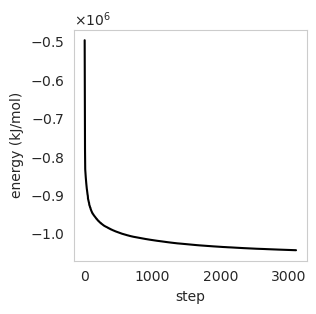

In [17]:
VACUUM_EDR = Path(f"{SOLVATED_GRO.stem}.edr")
VACUUM_XVG = Path(f"{SOLVATED_GRO.stem}.xvg")
!cd {WD} && echo "11" | gmx energy -f {VACUUM_EDR} -o {VACUUM_XVG} -xvg none

fig, ax = plt.subplots(figsize=(3, 3))
df = pd.read_csv(WD / VACUUM_XVG, sep='\s+', header=None, names=['step', 'energy'])
plt.plot(df["step"], df["energy"], color="black")
plt.xlabel("step")
plt.ylabel("energy (kJ/mol)")
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.grid(False)
plt.show()

## Equilibration - Temperature

Perform NVT (constant Number of particles, Volume, and Temperature) heating on the solvated protein system, 
where the system is gradually heated to the target temperature under constant volume conditions.

The main goals are:
- to slowly increase the temperature of the system, allowing it to adapt without causing structural distortions or instabilities.
- to equilibrate the kinetic energy distribution among the particles, ensuring a stable temperature before proceeding to subsequent simulation steps.

In [18]:
NVT_MDP = Path(GROMACS_PATH) / "nvt.mdp"
NVT_NN = f"{PROTEIN_PDB.stem}_NVT"
NVT_TPR = Path(f"{NVT_NN}.tpr")
!cd {WD} && gmx grompp -v -f {NVT_MDP} -c {SOLVATED_GRO} -p {PROTEIN_TOP} -r {SOLVATED_GRO} -o {NVT_TPR}
!cd {WD} && gmx mdrun -v -deffnm {NVT_NN} -s {NVT_TPR} -gpu_id 0

                      :-) GROMACS - gmx grompp, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/ProtMatch/notebooks/MD1/GFP/SM_17
Command line:
  gmx grompp -v -f /home/tz365/WS/ProtMatch/gromacs/nvt.mdp -c SM_17_waterRM_solvated.gro -p SM_17.top -r SM_17_waterRM_solvated.gro -o SM_17_NVT.tpr

Ignoring obsolete mdp entry 'ns_type'
Replacing old mdp entry 'nstxtcout' by 'nstxout-compressed'
checking input for internal consistency...

Setting the LD random seed to -538577937

processing topology...

Generated 167799 of the 167910 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'NA'

turning H bonds into constraints...


                      :-) GROMACS - gmx energy, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/ProtMatch/notebooks/MD1/GFP/SM_17
Command line:
  gmx energy -f SM_17_NVT.edr -o SM_17_NVT.xvg -xvg none -b 20

Opened SM_17_NVT.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Position-Rest.  12  Potential     
 13  Kinetic-En.     14  Total-Energy    15  Conserved-En.   16  Temperature   
 17  Pressure        18  Constr.-rmsd    19  Vir-XX          20  Vir-XY        
 21  Vir-XZ          22  Vir-YX  

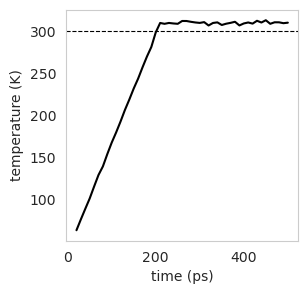

In [19]:
NVT_EDR = Path(f"{NVT_NN}.edr")
NVT_XVG = Path(f"{NVT_NN}.xvg")
!cd {WD} && echo "Temperature" | gmx energy -f {NVT_EDR} -o {NVT_XVG} -xvg none -b 20

fig, ax = plt.subplots(figsize=(3, 3))
df = pd.read_csv(WD / NVT_XVG, sep='\s+', header=None, names=['time', 'temperature'])
plt.plot(df["time"], df["temperature"], color="black")
plt.axhline(y=300, color='black', linestyle='--', linewidth=0.8)
plt.xlabel("time (ps)")
plt.ylabel("temperature (K)")
plt.grid(False)
plt.show()

## Equilibration - Pressure

NPT (constant Number of particles, Pressure, and Temperature) equilibration allows the system to adjust its volume to achieve the target temperature and pressure.

In [20]:
NPT_MDP = Path(GROMACS_PATH) / "npt.mdp"
NVT_GRO = Path(f"{NVT_NN}.gro")
NVT_CPT = Path(f"{NVT_NN}.cpt")
NPT_NN = f"{PROTEIN_PDB.stem}_NPT"
NPT_TPR = Path(f"{NPT_NN}.tpr")
!cd {WD} && gmx grompp -v -f {NPT_MDP} -c {NVT_GRO} -t {NVT_CPT} -p {PROTEIN_TOP} -o {NPT_TPR}
!cd {WD} && gmx mdrun -v -deffnm {NPT_NN} -s {NPT_TPR} -gpu_id 0

                      :-) GROMACS - gmx grompp, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/ProtMatch/notebooks/MD1/GFP/SM_17
Command line:
  gmx grompp -v -f /home/tz365/WS/ProtMatch/gromacs/npt.mdp -c SM_17_NVT.gro -t SM_17_NVT.cpt -p SM_17.top -o SM_17_NPT.tpr

Ignoring obsolete mdp entry 'ns_type'
Replacing old mdp entry 'nstxtcout' by 'nstxout-compressed'
checking input for internal consistency...

Setting the LD random seed to -402915699

processing topology...

Generated 167799 of the 167910 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 3 bonded neighb

                      :-) GROMACS - gmx energy, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/ProtMatch/notebooks/MD1/GFP/SM_17
Command line:
  gmx energy -f SM_17_NPT.edr -o SM_17_NPT.xvg -xvg none

Opened SM_17_NPT.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Potential       12  Kinetic-En.   
 13  Total-Energy    14  Conserved-En.   15  Temperature     16  Pressure      
 17  Constr.-rmsd    18  Box-X           19  Box-Y           20  Box-Z         
 21  Volume          22  Density       

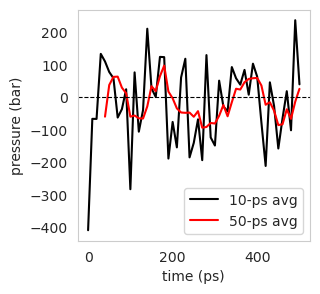

In [21]:
NPT_EDR = Path(f"{NPT_NN}.edr")
NPT_XVG = Path(f"{NPT_NN}.xvg")
!cd {WD} && echo "Pressure" | gmx energy -f {NPT_EDR} -o {NPT_XVG} -xvg none

fig, ax = plt.subplots(figsize=(3, 3))
df = pd.read_csv(WD / NPT_XVG, sep='\s+', header=None, names=['time', 'pressure'])
df['pressure_avg'] = df['pressure'].rolling(window=5).mean()
plt.plot(df["time"], df["pressure"], color="black", label='10-ps avg')
plt.plot(df["time"], df["pressure_avg"], color="red", linestyle='-', label='50-ps avg')
plt.axhline(y=1, color='black', linestyle='--', linewidth=0.8)
plt.xlabel("time (ps)")
plt.ylabel("pressure (bar)")
plt.legend(loc="lower right")
plt.grid(False)
plt.show()

                      :-) GROMACS - gmx energy, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/ProtMatch/notebooks/MD1/GFP/SM_17
Command line:
  gmx energy -f SM_17_NPT.edr -o SM_17_NPT_dens.xvg -xvg none

Opened SM_17_NPT.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Potential       12  Kinetic-En.   
 13  Total-Energy    14  Conserved-En.   15  Temperature     16  Pressure      
 17  Constr.-rmsd    18  Box-X           19  Box-Y           20  Box-Z         
 21  Volume          22  Density  

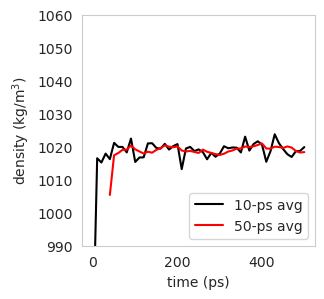

In [22]:
NPT_EDR = Path(f"{NPT_NN}.edr")
NPT_XVG = Path(f"{NPT_NN}_dens.xvg")
!cd {WD} && echo "Density" | gmx energy -f {NPT_EDR} -o {NPT_XVG} -xvg none

fig, ax = plt.subplots(figsize=(3, 3))
df = pd.read_csv(WD / NPT_XVG, sep='\s+', header=None, names=['time', 'density'])
df['density_avg'] = df['density'].rolling(window=5).mean()
plt.plot(df["time"], df["density"], color="black", label='10-ps avg')
plt.plot(df["time"], df["density_avg"], color="red", linestyle='-', label='50-ps avg')
plt.xlabel("time (ps)")
plt.ylabel("density (kg/m$^{3}$)")
plt.ylim((990, 1060))
plt.legend(loc="lower right")
plt.grid(False)
plt.show()

## Production

Perform a production simulation under NPT conditions to gather dynamic data about the system.
The goal is to simulate the behavior of the solvated and neutralized protein in an environment that mimics physiological conditions.

This phase collects detailed molecular dynamics data on the behavior of the protein and its surrounding solvent molecules under conditions that closely mimic a natural, physiological environment.

Running the simulation under constant pressure and temperature ensures that the system's volume can adjust dynamically, providing a more realistic representation of biological conditions.

The data obtained from this production run can be used to analyze various aspects of the protein's behavior, such as conformational changes, stability, interactions with solvent molecules, and other dynamic properties.

In [23]:
PROD_MDP = Path(GROMACS_PATH) / "prod.mdp"
NPT_GRO = Path(f"{NPT_NN}.gro")
NPT_CPT = Path(f"{NPT_NN}.cpt")
PROD_NN = f"{PROTEIN_PDB.stem}_PROD"
PROD_TPR = Path(f"{PROD_NN}.tpr")
!cd {WD} && gmx grompp -v -f {PROD_MDP} -c {NPT_GRO} -t {NPT_CPT} -p {PROTEIN_TOP} -o {PROD_TPR}
!cd {WD} && gmx mdrun -v -deffnm {PROD_NN} -s {PROD_TPR} -gpu_id 0

                      :-) GROMACS - gmx grompp, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/ProtMatch/notebooks/MD1/GFP/SM_17
Command line:
  gmx grompp -v -f /home/tz365/WS/ProtMatch/gromacs/prod.mdp -c SM_17_NPT.gro -t SM_17_NPT.cpt -p SM_17.top -o SM_17_PROD.tpr

Ignoring obsolete mdp entry 'ns_type'
Replacing old mdp entry 'nstxtcout' by 'nstxout-compressed'
checking input for internal consistency...

Setting the LD random seed to -554468526

processing topology...

Generated 167799 of the 167910 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 1

Generated 117432 of the 167910 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein'

turning H bonds into constraints...

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 3 bonded neig

In [24]:
!rm -rf {WD}/charmm36-nov2016.ff

Now, convert some trajectories to PDB for subsequent analysis (ie. phylogenetic tree confidence).

In [25]:
!cd {WD} && gmx check -f {NPT_NN}.xtc

                      :-) GROMACS - gmx check, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/ProtMatch/notebooks/MD1/GFP/SM_17
Command line:
  gmx check -f SM_17_NPT.xtc

Checking file SM_17_NPT.xtc
Reading frame       0 time    0.000   
# Atoms  63423
Precision 0.001 (nm)
Last frame         50 time  500.000   


Item        #frames Timestep (ps)
Step            51    10
Time            51    10
Lambda           0
Coords          51    10
Velocities       0
Forces           0
Box             51    10

GROMACS reminds you: "It is not critical to add the next quote to a patch release" (Paul Bauer)



In [26]:
MAX_TIME = 200  # You can get this from the previous command.
os.mkdir(WD / "trajectories")
for i, t in enumerate(range(0, MAX_TIME, 10)):
    !cd {WD} && echo "Protein" | gmx trjconv -s {PROD_TPR} -f {PROD_NN}.xtc -o trajectories/trj{i}.pdb -dump {t}

                     :-) GROMACS - gmx trjconv, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/ProtMatch/notebooks/MD1/GFP/SM_17
Command line:
  gmx trjconv -s SM_17_PROD.tpr -f SM_17_PROD.xtc -o trajectories/trj0.pdb -dump 0

Note that major changes are planned in future for trjconv, to improve usability and utility.
Will write pdb: Protein data bank file
Reading file SM_17_PROD.tpr, VERSION 2024.2 (single precision)
Reading file SM_17_PROD.tpr, VERSION 2024.2 (single precision)
Select group for output
Group     0 (         System) has 63423 elements
Group     1 (        Protein) has  3724 elements
Group     2 (      Protein-H) has  1838 elements
Group     3 (        C-alpha) has   238 elements
Group     4 (       Backbone) has   714 elements
Group     5 (      MainChain) has   951 elements
Group     6 (   MainChain+Cb) has  1163 elements
Group     7 (    MainChain+H) has  1176 elements
Group     8 (      SideChain) h

## Stability Evaluation

In [27]:
# os.environ['PATH'] = '/usr/local/gromacs/bin:' + os.environ['PATH']
# 
# PROTEIN_CLS = "BLDB"
# PROTEIN_SID = "SM_12"
# assert PROTEIN_CLS is not None
# assert PROTEIN_SID is not None
# PROTEIN_PDB = Path(f"../data/{PROTEIN_CLS}/generated/BQSH/{PROTEIN_SID}.pdb")
# 
# # Create a new working directory!
# WD = Path(f"MD1/{PROTEIN_CLS}/{PROTEIN_SID}")
# assert WD.exists()
# 
# PROD_NN = f"{PROTEIN_PDB.stem}_PROD"
# PROD_TPR = Path(f"{PROD_NN}.tpr")

### RMSD

Calculate the Root Mean Square Deviation (RMSD) of a molecular dynamics trajectory. 
RMSD measures the average deviation of a set of atomic positions from a reference structure, which is the initial structure. 

Here, we only calculate RMSD for Backbone (group 4).

1. **Low RMSD Values (0.1 - 0.3 nm or 1 - 3 $\mathring{\text{A}}$)**: The protein structure is very stable.

2. **Moderate RMSD Values (0.3 - 0.5 nm or 3 - 5 $\mathring{\text{A}}$)**: The protein structure is reasonably stable with some flexibility.

3. **High RMSD Values (>0.5 nm or >5 $\mathring{\text{A}}$)**: The protein structure may be unstable.

Regardless of the absolute RMSD value, a key indicator of stability is how the RMSD evolves over time. 
A stable protein will show an initial rise in RMSD as it equilibrates and then plateau, indicating it has reached a stable conformation.
 Once the RMSD reaches a steady state and fluctuates within a narrow range, the protein can be considered stable. 
 The exact RMSD value at the plateau will depend on the protein and the simulation conditions.

In [28]:
PROD_XTC = Path(f"{PROD_NN}.xtc")
RMSD_OUT_XVG = Path("RMSD.xvg")
!cd {WD} && echo "4 4" | gmx rms -s {PROD_TPR} -f {PROD_XTC} -o {RMSD_OUT_XVG} -tu ns

                       :-) GROMACS - gmx rms, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/ProtMatch/notebooks/MD1/GFP/SM_17
Command line:
  gmx rms -s SM_17_PROD.tpr -f SM_17_PROD.xtc -o RMSD.xvg -tu ns

Reading file SM_17_PROD.tpr, VERSION 2024.2 (single precision)
Reading file SM_17_PROD.tpr, VERSION 2024.2 (single precision)
Select group for least squares fit
Group     0 (         System) has 63423 elements
Group     1 (        Protein) has  3724 elements
Group     2 (      Protein-H) has  1838 elements
Group     3 (        C-alpha) has   238 elements
Group     4 (       Backbone) has   714 elements
Group     5 (      MainChain) has   951 elements
Group     6 (   MainChain+Cb) has  1163 elements
Group     7 (    MainChain+H) has  1176 elements
Group     8 (      SideChain) has  2548 elements
Group     9 (    SideChain-H) has   887 elements
Group    10 (    Prot-Masses) has  3724 elements
Group    11 (    non-Prot

In [29]:
def read_xvg(file_path, columns):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            if not line.startswith(('@', '#')):  # Skip header lines
                data.append([float(x) for x in line.split()])
    return pd.DataFrame(data, columns=columns)

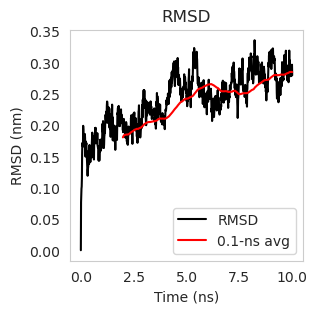

0.23897273696303695 pm 0.044355225668876216


In [30]:
rmsd_df_columns = ["Time (ns)", "RMSD (nm)"]
rmsd_df = read_xvg(WD / RMSD_OUT_XVG, columns=rmsd_df_columns)
plt.figure(figsize=(3, 3))
plt.plot(rmsd_df[rmsd_df_columns[0]], rmsd_df[rmsd_df_columns[1]], label='RMSD', color="black")
plt.plot(rmsd_df[rmsd_df_columns[0]],
         rmsd_df[rmsd_df_columns[1]].rolling(window=200).mean(),
         label='0.1-ns avg', color="red")
plt.xlabel(rmsd_df_columns[0])
plt.ylabel(rmsd_df_columns[1])
plt.title('RMSD')
plt.grid(False)
plt.legend()
plt.show()
print(f"{np.mean(rmsd_df[rmsd_df_columns[1]])} pm {np.std(rmsd_df[rmsd_df_columns[1]])}")

### RMSF

Calculate the Root Mean Square Fluctuation (RMSF) of the atoms or residues in a molecular dynamics (MD) simulation.

By calculating RMSF, wecan identify which parts of the protein (or other macromolecule) are more flexible or dynamic. Regions with high RMSF values are more flexible, whereas regions with low RMSF values are more rigid.

The formula for RMSF is:
$$
\text{RMSF}(i) = \sqrt{\frac{1}{N} \sum_{t=1}^{N} (r_i(t) - \langle r_i \rangle)^2}
$$

1. **Low RMSF Values**: Regions of the protein with low RMSF values are relatively stable and do not deviate much from their average positions. These stable regions often correspond to secondary structures like alpha-helices and beta-sheets, which maintain their conformation throughout the simulation.

2. **High RMSF Values**: High RMSF values indicate flexible or dynamic regions that move significantly during the simulation. These regions can correspond to loops, termini, or other flexible parts of the protein.

In [31]:
RMSF_OUT_XVG = Path("RMSF.xvg")
!cd {WD} && echo "4" | gmx rmsf -s {PROD_TPR} -f {PROD_XTC} -o {RMSF_OUT_XVG} -res

                       :-) GROMACS - gmx rmsf, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/ProtMatch/notebooks/MD1/GFP/SM_17
Command line:
  gmx rmsf -s SM_17_PROD.tpr -f SM_17_PROD.xtc -o RMSF.xvg -res

Reading file SM_17_PROD.tpr, VERSION 2024.2 (single precision)
Reading file SM_17_PROD.tpr, VERSION 2024.2 (single precision)
Select group(s) for root mean square calculation
Group     0 (         System) has 63423 elements
Group     1 (        Protein) has  3724 elements
Group     2 (      Protein-H) has  1838 elements
Group     3 (        C-alpha) has   238 elements
Group     4 (       Backbone) has   714 elements
Group     5 (      MainChain) has   951 elements
Group     6 (   MainChain+Cb) has  1163 elements
Group     7 (    MainChain+H) has  1176 elements
Group     8 (      SideChain) has  2548 elements
Group     9 (    SideChain-H) has   887 elements
Group    10 (    Prot-Masses) has  3724 elements
Group    11

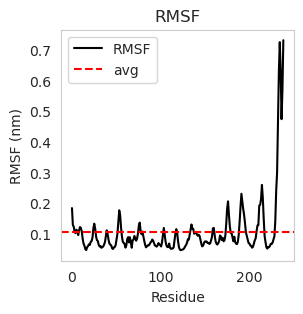

0.10589957983193278 pm 0.09719574959492447


In [32]:
rmsf_df_columns = ["Residue", "RMSF (nm)"]
rmsf_df = read_xvg(WD / RMSF_OUT_XVG, columns=rmsf_df_columns)
plt.figure(figsize=(3, 3))
plt.plot(rmsf_df[rmsf_df_columns[0]], rmsf_df[rmsf_df_columns[1]], label='RMSF', color="black")
plt.axhline(y=np.mean(rmsf_df[rmsf_df_columns[1]]), color="red", label="avg", linestyle="--")
plt.xlabel(rmsf_df_columns[0])
plt.ylabel(rmsf_df_columns[1])
plt.legend()
plt.title('RMSF')
plt.grid(False)
plt.show()
print(f"{np.mean(rmsf_df[rmsf_df_columns[1]])} pm {np.std(rmsf_df[rmsf_df_columns[1]])}")

### Radius of Gyration, Rg

Calculate the radius of gyration of a molecule throughout the MD simulation. The radius of gyration is a measure of the distribution of the mass of the molecule around its center of mass. A stable Rg value indicates that the protein is maintaining its overall shape and not unfolding or collapsing.

In [33]:
RG_OUT_XVG = Path("RG.xvg")
!cd {WD} && echo "4" | gmx gyrate -s {PROD_TPR} -f {PROD_XTC} -o {RG_OUT_XVG}

                      :-) GROMACS - gmx gyrate, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/ProtMatch/notebooks/MD1/GFP/SM_17
Command line:
  gmx gyrate -s SM_17_PROD.tpr -f SM_17_PROD.xtc -o RG.xvg

Reading file SM_17_PROD.tpr, VERSION 2024.2 (single precision)
Reading file SM_17_PROD.tpr, VERSION 2024.2 (single precision)
Last frame       1000 time 10000.000   
Analyzed 1001 frames, last time 10000.000

GROMACS reminds you: "Would You Like to Be the Monster Tonight ?" (Captain Beefheart)



1.7772745574425575 pm 0.015662588460521567
1.299985825174825 pm 0.06629489513942127
1.4757404375624374 pm 0.06840634531191835
1.5617473876123875 pm 0.04469858665678917


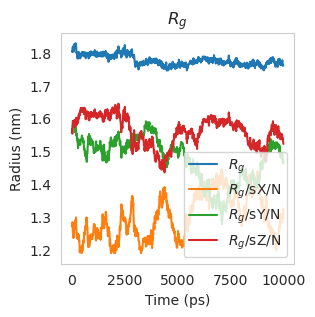

In [34]:
rg_df_columns = ["Time (ps)", "$R_g$", "$R_g$/sX/N", "$R_g$/sY/N", "$R_g$/sZ/N"]
rg_df = read_xvg(WD / RG_OUT_XVG, columns=rg_df_columns)
plt.figure(figsize=(3, 3))
for i in range(1, len(rg_df_columns)):
    plt.plot(rg_df[rg_df_columns[0]], rg_df[rg_df_columns[i]], label=rg_df_columns[i])
    print(f"{np.mean(rg_df[rg_df_columns[i]])} pm {np.std(rg_df[rg_df_columns[i]])}")
    # plt.plot(rg_df[rg_df_columns[0]], 
    #          rg_df[rg_df_columns[i]].rolling(window=200).mean())
plt.xlabel('Time (ps)')
plt.ylabel('Radius (nm)')
plt.title('$R_g$')
# plt.legend(loc='right', bbox_to_anchor=(1.52, 0.5))
plt.legend(loc='lower right')
plt.grid(False)
# plt.ylim((0, 1.5))
plt.show()

### Secondary Structure Count

Track changes in its secondary structure elements, such as alpha-helices and beta-sheets. How the overall secondary structure composition of the protein changes during the simulation?
   
If the number of residues in helices, sheets, or other structures remains relatively constant, it indicates structural stability.

In [35]:
DSSP_OUT_XVG = Path("DSSP.xvg")
!cd {WD} && gmx dssp -s {PROD_TPR} -f {PROD_XTC} -o {DSSP_OUT_XVG.stem}.dat -num {DSSP_OUT_XVG} -hmode dssp -clear

                       :-) GROMACS - gmx dssp, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/ProtMatch/notebooks/MD1/GFP/SM_17
Command line:
  gmx dssp -s SM_17_PROD.tpr -f SM_17_PROD.xtc -o DSSP.dat -num DSSP.xvg -hmode dssp -clear

Reading file SM_17_PROD.tpr, VERSION 2024.2 (single precision)
Reading file SM_17_PROD.tpr, VERSION 2024.2 (single precision)
Last frame       1000 time 10000.000   
Analyzed 1001 frames, last time 10000.000

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
W. Kabsch, C. Sander
Dictionary of protein secondary structure: pattern recognition of
hydrogen-bonded and geometrical features.
Biopolymers 22 (1983) pp. 2577-2637
-------- -------- --- Thank You --- -------- --------


++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
S. Gorelov, A. Titov, O. Tolicheva, A. Konevega, A. Shvetsov
DSSP in GROMACS: Tool for Defining Secondary Structures of Proteins in
Trajectories
Journal of C

40.866133866133865 pm 3.988502699544984
0.0 pm 0.0
23.3986013986014 pm 3.628607343142433
27.836163836163838 pm 4.763867801765498
3.6483516483516483 pm 2.3256850537530918
0.3696303696303696 pm 1.3082527424006398
7.8001998001998 pm 2.954540683319594
113.52147852147853 pm 3.4798963394410185
1.100899100899101 pm 0.8259098399616283
18.458541458541458 pm 4.070621514095661


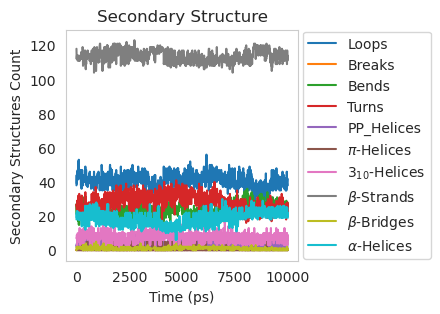

In [36]:
dssp_df_columns = ["Time (ps)", "Loops", "Breaks", "Bends", "Turns", "PP_Helices", "$\\pi$-Helices", "$3_{10}$-Helices",
                   "$\\beta$-Strands", "$\\beta$-Bridges", "$\\alpha$-Helices"]
dssp_df = read_xvg(WD / DSSP_OUT_XVG, columns=dssp_df_columns)
plt.figure(figsize=(3, 3))
for i in range(1, len(dssp_df_columns)):
    plt.plot(dssp_df[dssp_df_columns[0]], dssp_df[dssp_df_columns[i]], label=dssp_df_columns[i])
    print(f"{np.mean(dssp_df[dssp_df_columns[i]])} pm {np.std(dssp_df[dssp_df_columns[i]])}")
plt.xlabel('Time (ps)')
plt.ylabel('Secondary Structures Count')
plt.title('Secondary Structure')
plt.legend(loc='right', bbox_to_anchor=(1.6, 0.5))
plt.grid(False)
plt.show()

### Energy Analysis

In [37]:
PROD_EDR = Path(f"{PROD_NN}.edr")

In [38]:
TOTAL_ENERGY_XVG = Path(f"{PROD_NN}_total_energy.xvg")
!cd {WD} && echo "Total-Energy" | gmx energy -f {PROD_EDR} -o {TOTAL_ENERGY_XVG} -xvg none

POTENTIAL_ENERGY_XVG = Path(f"{PROD_NN}_potential_energy.xvg")
!cd {WD} && echo "Potential" | gmx energy -f {PROD_EDR} -o {POTENTIAL_ENERGY_XVG} -xvg none

KINETIC_ENERGY_XVG = Path(f"{PROD_NN}_kinetic_energy.xvg")
!cd {WD} && echo "Kinetic-En." | gmx energy -f {PROD_EDR} -o {KINETIC_ENERGY_XVG} -xvg none

                      :-) GROMACS - gmx energy, 2024.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/tz365/WS/ProtMatch/notebooks/MD1/GFP/SM_17
Command line:
  gmx energy -f SM_17_PROD.edr -o SM_17_PROD_total_energy.xvg -xvg none

Opened SM_17_PROD.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  U-B              3  Proper-Dih.      4  Improper-Dih. 
  5  CMAP-Dih.        6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Potential       12  Kinetic-En.   
 13  Total-Energy    14  Conserved-En.   15  Temperature     16  Pressure      
 17  Constr.-rmsd    18  Box-X           19  Box-Y           20  Box-Z         
 21  Volume          22

-697281.39753996 pm 1337.5721478184744
-863289.940934066 pm 1050.4493693202078
166008.5435658092 pm 702.9965275152421


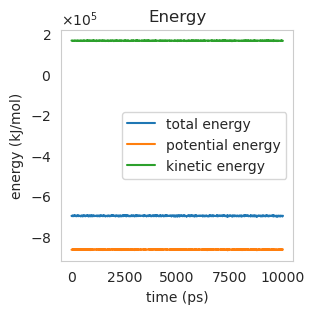

In [39]:
tot_en_df = pd.read_csv(WD / TOTAL_ENERGY_XVG, sep='\s+', header=None, names=['step', 'Total-Energy'])
pot_en_df = pd.read_csv(WD / POTENTIAL_ENERGY_XVG, sep='\s+', header=None, names=['step', 'Potential-Energy'])
ktc_en_df = pd.read_csv(WD / KINETIC_ENERGY_XVG, sep='\s+', header=None, names=['step', 'Kinetic-Energy'])


print(f"{np.mean(tot_en_df['Total-Energy'])} pm {np.std(tot_en_df['Total-Energy'])}")
print(f"{np.mean(pot_en_df['Potential-Energy'])} pm {np.std(pot_en_df['Potential-Energy'])}")
print(f"{np.mean(ktc_en_df['Kinetic-Energy'])} pm {np.std(ktc_en_df['Kinetic-Energy'])}")

fig, ax = plt.subplots(figsize=(3, 3))
plt.plot(tot_en_df["step"], tot_en_df["Total-Energy"], label="total energy")
plt.plot(pot_en_df["step"], pot_en_df["Potential-Energy"], label="potential energy")
plt.plot(ktc_en_df["step"], ktc_en_df["Kinetic-Energy"], label="kinetic energy")
plt.xlabel("time (ps)")
plt.ylabel("energy (kJ/mol)")
plt.legend()
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.grid(False)
plt.title("Energy")
plt.show()

### Contact Map (Deperated)

A contact map is a 2D matrix where each cell (i, j) represents the contact (usually within a certain distance threshold, like 0.5 nm) between residue i and residue j over the course of the simulation. A high value in a cell indicates frequent contacts between those residues.

**Consistency of Contacts**:
- **Stable Regions**: Residues that maintain consistent contacts throughout the simulation indicate stable regions of the protein. In the contact map, these appear as persistent spots or clusters of high values.
- **Unstable Regions**: Regions where contacts are inconsistent or transient indicate flexible or unstable parts of the protein. These regions will show as dispersed or low-value spots in the contact map.

In [40]:
# CONTACT_XVG = Path("CONTACT.xvg")
# CONTACT_XPM = Path(f"{CONTACT_XVG.stem}.xpm")
# !cd {WD} && echo "4" | gmx mdmat -s {PROD_TPR} -f {PROD_XTC} -mean {CONTACT_XPM} -no {CONTACT_XVG}

In [41]:
# !cd {WD} && gmx xpm2ps -f {CONTACT_XPM} -o {CONTACT_XPM.stem}.eps
# import matplotlib.image as mpimg
# 
# img = mpimg.imread(WD / f"{CONTACT_XPM.stem}.eps")
# 
# plt.figure(figsize=(2, 2), dpi=300)
# plt.imshow(img)
# plt.axis('off')
# plt.show()